## Correlation Analysis
Here are the steps taken:
1. importing packages
2. loading twitter data
3. loading historical data
4. preprocessing the datasets
5. calculating sentiment polarity using VADER
6. merging price and sentiment data based on their intervals
7. selecting the suitable interval for the analysis using cross-correlation
8. selecting the suitable MA/EMA hyperparameter (assuming context improves sentiment index)
9. storing the selected index as a dataset to be used later

### importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\USER\AppData\Local\Temp\ipykernel_11200\3888849287.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import sys
import os
current_working_directory = os.getcwd()
sys.path.append(os.path.dirname(current_working_directory))
from util.eda import generate_report

In [4]:
# configs
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("using debug mode")
tqdm.pandas()
plt.style.use('ggplot')

In [5]:
tqdm.pandas()

In [116]:
# constants
DATASET_DIRECTORY = os.path.join(os.path.dirname(current_working_directory), "dataset")
RAW_DIRECTORY = os.path.join(os.path.dirname(current_working_directory), "raw")
RESULT_DIRESTORY = os.path.join(os.path.dirname(current_working_directory), "result/correlation_analysis")
BITCOIN_TWEETS_RAW_ADDRESS = os.path.join(RAW_DIRECTORY, "/bitcoin-tweets/Bitcoin_tweets.csv")
CLEAN_DATASET_FILENAME = "_correlation_analysis_clean.csv"
SLICED_DATASET_FILENAME="_correlation_analysis_sliced.csv"
SLICED_START_TIME="2021-07-17 12:00:00"
SLICED_END_TIME="2021-07-30"

### loading twitter data

In [35]:
def clean_dataset(source: pd.DataFrame):
    """
    This function cleans the input DataFrame by:
    - Converting 'user_followers' and 'user_friends' columns to integer type
    - Converting 'user_verified' column to boolean type
    - Converting 'date' column to datetime type
    - Dropping rows with any null values
    - Setting 'date' as the index of the DataFrame
    It then returns the cleaned DataFrame.
    """
    df = source.copy()
    df["user_followers"] = pd.to_numeric(df["user_followers"], errors='coerce').astype('Int64')
    df["user_friends"] = pd.to_numeric(df["user_friends"], errors='coerce').astype('Int64')
    df["user_verified"] = df["user_verified"].astype("bool")
    df["date"] = pd.to_datetime(df["date"], errors='coerce')
    df = df.dropna().set_index("date")
    return df

def handle_dataset(file_path, df=None, columns=None, index="date"):
    """
    This function handles the reading and writing of datasets.
    - If a DataFrame is provided, it writes the DataFrame to a CSV file at the given file path.
    - If no DataFrame is provided, it checks if a file exists at the given file path and reads it if it does.
    - If no file exists, it returns None.
    """
    if df is not None:
        logging.debug(f"Writing to csv at {file_path}")
        df.to_csv(file_path)
    elif os.path.isfile(file_path):
        logging.debug(f"Reading dataset from {file_path}")
        return pd.read_csv(file_path, usecols=columns).set_index(index)
    return None

def slice_dataframe(sdf, start_datetime, end_datetime):
    """
    This function slices a DataFrame based on a given date range.
    - It first sorts the DataFrame by 'date'.
    - It then slices the DataFrame based on the given start and end datetime.
    - It returns the sliced DataFrame.
    """
    sorted_df = sdf.sort_values(by='date')
    sliced_df = sorted_df.loc[start_datetime:end_datetime]
    return sliced_df

def get_dataframe(source_dataset_address, clean_dataset_address, sliced_dataset_address, start_time, end_time):
    """
    This function gets a DataFrame from a given file path.
    - It first tries to read a sliced dataset from a given file path.
    - If no sliced dataset exists, it tries to read a clean dataset from a given file path.
    - If no clean dataset exists, it generates a clean dataset from a source dataset.
    - It then slices the DataFrame and writes it to a CSV file.
    - It returns the DataFrame.
    """
    columns = ['user_followers', 'user_friends', 'user_verified', 'date', 'text']

    df = handle_dataset(sliced_dataset_address, columns=columns)
    if df is None:
        df = handle_dataset(clean_dataset_address, columns=columns)
        if df is None:
            logging.debug("Generating clean dataset from source")
            df = pd.read_csv(source_dataset_address, lineterminator='\n', usecols=columns)
            df = clean_dataset(df)
            handle_dataset(clean_dataset_address, df=df)
        df = slice_dataframe(df, start_time, end_time)
        handle_dataset(sliced_dataset_address, df=df)

    return df

In [36]:
# Check to see if the cleaned version of dataset exists. if not, we build the dataframe from the source.
clean_dataset_address = os.path.join(DATASET_DIRECTORY, CLEAN_DATASET_FILENAME)
sliced_dataset_address = os.path.join(DATASET_DIRECTORY, SLICED_DATASET_FILENAME)
df = get_dataframe(BITCOIN_TWEETS_RAW_ADDRESS, clean_dataset_address, sliced_dataset_address, SLICED_START_TIME, SLICED_END_TIME)

In [37]:
df

,user_followers,user_friends,user_verified,text
date,,,,
2021-07-17 12:00:00,1534,2044,False,"Baller, Jack Mallers Calls Out Brian Armstrong..."
2021-07-17 12:00:00,27309,166,False,Square developing #bitcoin-focused business as...
2021-07-17 12:00:00,34,19,False,#Bitcoin\nCurrent Price:\n$ 31397.97\n€ 26640....
2021-07-17 12:00:00,953,119,False,Now tell me looking straight into my eyes that...
2021-07-17 12:00:00,145324,834,True,There are a number of walk-in NHS vaccination ...
...,...,...,...,...
2021-07-29 23:59:12,73,583,False,This only has 1k views? WTF #CRYPTO #Bitcoin #...
2021-07-29 23:59:14,413361,387,False,LET'S DISCUSS THE LATEST #CRYPTO NEWS!\n\n-- P...
2021-07-29 23:59:21,60,1049,False,@fireworksdoge Address : 0x01F69047c11DD924631...


In [10]:
df.dtypes

user_followers     int64
user_friends       int64
user_verified       bool
text              object
dtype: object

### loading historical data

In [38]:
historical_intervals = [300, 900, 1800, 3600]
columns = ["timestamp", "open", "high", "low", "close", "volume", "trade"]
historical_dfs = {}
for interval in historical_intervals:
    file_path = f"{RAW_DIRECTORY}/{interval}-sliced.csv"
    print(file_path)
    historical_df = handle_dataset(file_path=file_path, columns=columns, index='timestamp')
    historical_df.index = pd.to_datetime(historical_df.index, unit='s')
    # excluding the last index to match the sentiment dataset shape
    historical_dfs[interval] = historical_df[:-1]
del(historical_df)

d:\Daneshgah\MyPaper\github\Financial_NLP\raw/300-sliced.csv
d:\Daneshgah\MyPaper\github\Financial_NLP\raw/900-sliced.csv
d:\Daneshgah\MyPaper\github\Financial_NLP\raw/1800-sliced.csv
d:\Daneshgah\MyPaper\github\Financial_NLP\raw/3600-sliced.csv


In [12]:
historical_dfs.keys()

dict_keys([300, 900, 1800, 3600])

### preprocessing the datasets

- remove URLS (regex)
- lower case all the tweets
- remove (remove all punctuations except for meaningful ones like :( or !, ?)
- extract hashtags to another column
- replace #BTC, #Bitcoin, #bitcoin, replace with BTC.
- replace BTC, Bitcoin, bitcoin, with BTC
- remove user ids beginning with @
- extract emojis and emoticons to their separate column
- remove ads

### calculating sentiment polarity using VADER

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
sia = SentimentIntensityAnalyzer()

In [39]:
columns = ['user_followers', 'user_friends', 'user_verified', 'date', 'text', 'negative', 'neutral', 'positive', 'compound']
vader_dataset_name = "_correlation_analysis_sentiment.csv"
vader_dataset_address = os.path.join(DATASET_DIRECTORY, vader_dataset_name)
vader_df = handle_dataset(file_path=vader_dataset_address, columns=columns)
if vader_df is None:
    vader_df = df.copy()
    vader_df[['negative', 'neutral', 'positive', 'compound']] = vader_df['text'].progress_apply(lambda text: pd.Series(sia.polarity_scores(text)))
    handle_dataset(file_path=vader_dataset_address, df=vader_df)

100%|██████████| 331234/331234 [02:11<00:00, 2511.29it/s]


In [40]:
vader_df

,user_followers,user_friends,user_verified,text,negative,neutral,positive,compound
date,,,,,,,,
2021-07-17 12:00:00,1534,2044,False,"Baller, Jack Mallers Calls Out Brian Armstrong...",0.000,1.000,0.000,0.0000
2021-07-17 12:00:00,27309,166,False,Square developing #bitcoin-focused business as...,0.000,1.000,0.000,0.0000
2021-07-17 12:00:00,34,19,False,#Bitcoin\nCurrent Price:\n$ 31397.97\n€ 26640....,0.000,1.000,0.000,0.0000
2021-07-17 12:00:00,953,119,False,Now tell me looking straight into my eyes that...,0.100,0.810,0.090,-0.0516
2021-07-17 12:00:00,145324,834,True,There are a number of walk-in NHS vaccination ...,0.000,0.973,0.027,0.0772
...,...,...,...,...,...,...,...,...
2021-07-29 23:59:12,73,583,False,This only has 1k views? WTF #CRYPTO #Bitcoin #...,0.335,0.665,0.000,-0.6739
2021-07-29 23:59:14,413361,387,False,LET'S DISCUSS THE LATEST #CRYPTO NEWS!\n\n-- P...,0.114,0.886,0.000,-0.5599
2021-07-29 23:59:21,60,1049,False,@fireworksdoge Address : 0x01F69047c11DD924631...,0.000,0.784,0.216,0.7003


In [41]:
vader_df.index = pd.to_datetime(vader_df.index)

# Initialize a dictionary to store the resampled DataFrames
resampled_dfs = {}

sentiment_intervals = ['5min', '15min', '30min', 'h']
# Resample to intervals and aggregate sentiment scores
for interval in sentiment_intervals:
    resampled_dfs[interval] = vader_df.resample(interval).agg({
        'negative': 'mean',
        'neutral': 'mean',
        'positive': 'mean',
        'compound': 'mean',
        'text': 'count'
    })

In [19]:
resampled_dfs.keys()

dict_keys(['5min', '15min', '30min', 'h'])

In [33]:
np.save('resampled_sentiment.npy', resampled_dfs) 

### merging price and sentiment data based on their intervals

In [136]:
def plot_scatters(df, rows, columns, results_directory, interval):
    """
    for the columns and rows it plots the scatter and save the figure to the given address
    save the address as results_directory/scatter-row-column.jpg or whatever
    
    """
    plt.figure(figsize=(20, 30))
    # rows = ["compound", "positive", "negative", "neutral"]
    # columns = ["close", "open", "volume"]
    index = 1
    for row in rows:
        for column in columns:
            plt.subplot(len(rows), len(columns), index)
            plt.title(f"col: {column}, row: {row}")
            plt.scatter(x=df[column], y=df[row], s=df.text)
            missing_values = np.isnan(df[column]) | np.isnan(df[row])
            correlation_coefficient = np.corrcoef(df[column][~missing_values], df[row][~missing_values])[0, 1]
            plt.text(0.05, 0.95, f'Corr: {correlation_coefficient:.2f}', 
                     horizontalalignment='left', verticalalignment='top', 
                     transform=plt.gca().transAxes, fontsize=10)
            index += 1
    plt.savefig(f'{results_directory}\\{interval}.png')
    plt.close()

roc = lambda x: (x / x.shift(1) - 1)

In [73]:
m5 = pd.concat([historical_dfs[300], resampled_dfs["5min"]], axis=1)
h1 = pd.concat([historical_dfs[3600], resampled_dfs["h"]], axis=1)

In [74]:
h1

,open,high,low,close,volume,trade,negative,neutral,positive,compound,text
2021-07-17 12:00:00,31377.01,31570.00,31330.12,31489.01,14325.922,116879,0.035551,0.856775,0.107671,0.212476,960
2021-07-17 13:00:00,31489.00,31750.00,31329.00,31607.99,29114.409,214698,0.040247,0.848110,0.111610,0.237297,1064
2021-07-17 14:00:00,31607.99,31738.83,31572.00,31622.35,15550.348,125076,0.035694,0.843100,0.121208,0.287545,1247
2021-07-17 15:00:00,31621.48,31750.00,31433.72,31737.92,23013.314,164851,0.030764,0.834260,0.134966,0.316867,1223
2021-07-17 16:00:00,31737.87,31849.00,31614.72,31677.24,24002.979,174697,0.031505,0.837822,0.130668,0.287229,1241
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-29 19:00:00,39532.41,39739.06,39451.22,39647.85,10995.427,129231,0.023090,0.862822,0.114080,0.290982,724
2021-07-29 20:00:00,39647.85,39830.00,39600.00,39715.49,7881.098,102117,0.020093,0.873400,0.106510,0.286185,625
2021-07-29 21:00:00,39715.49,39761.11,39465.66,39522.27,9108.069,107487,0.025932,0.862483,0.111586,0.274966,497
2021-07-29 22:00:00,39522.61,39812.34,39506.81,39773.85,9615.746,111277,0.020245,0.868178,0.111570,0.300249,477


In [76]:
h1.negative.describe()

count    300.000000
mean       0.030006
std        0.007241
min        0.002973
25%        0.025924
50%        0.029501
75%        0.034566
max        0.054945
Name: negative, dtype: float64

In [45]:
# plt.scatter(x=m5.negative[1:], y=m5.close.diff())
m5.close.diff()

2021-07-17 12:00:00       NaN
2021-07-17 12:05:00     47.85
2021-07-17 12:10:00     26.98
2021-07-17 12:15:00     -4.83
2021-07-17 12:20:00     44.27
                        ...  
2021-07-29 23:35:00      3.27
2021-07-29 23:40:00    -44.93
2021-07-29 23:45:00   -139.16
2021-07-29 23:50:00     54.47
2021-07-29 23:55:00      7.62
Name: close, Length: 3600, dtype: float64

In [137]:

m5 = pd.concat([historical_dfs[300], resampled_dfs["5min"]], axis=1)
m15 = pd.concat([historical_dfs[900], resampled_dfs["15min"]], axis=1)
m30 = pd.concat([historical_dfs[1800], resampled_dfs["30min"]], axis=1)
h1 = pd.concat([historical_dfs[3600], resampled_dfs["h"]], axis=1)
intervals = [{"m5": m5},{"m15":m15},{"m30":m30},{"h1":h1}]
columns = ['negative', 'neutral', 'positive', 'compound']
rows = ['roc', 'volume_roc']
# write a for loop that iterates on all given intervals and merges the sentiment, historical dataframe and plots the scatters
for interval in intervals:
    interval_name = list(interval.keys())[0]
    interval_df = list(interval.values())[0]
    interval_df["roc"] = roc(interval_df["close"])
    interval_df["volume_roc"] = roc(interval_df["volume"])
    plot_scatters(interval_df, columns, rows, RESULT_DIRESTORY, interval_name)

### calculating the cross correlation between sentiment and price

In [143]:
m5_df["roc"] = (m5_df["close"] / m5_df["close"].shift(1) - 1)
# m5_roc_compound["roc"] = m5_roc_compound["roc"].cumsum()

In [144]:
m5_df["compound_diffs"] = m5_df["compound"] / m5_df["compound"].shift(1) -1
# m5_roc_compound["compound_diffs"] = m5_roc_compound["compound_diffs"].cumsum()

In [145]:
m5_df["volume"] = historical_dfs[300]["volume"] / historical_dfs[300]["volume"].shift(1) -1

In [146]:
# Create a scaler object
scaler = MinMaxScaler()

# Fit and transform the data
m5_df["compound_diffs"] = scaler.fit_transform(m5_df[["compound_diffs"]])
m5_df["volume"] = scaler.fit_transform(m5_df[["volume"]])
m5_df["roc"] = scaler.fit_transform(m5_df[["roc"]])

In [147]:
m5_df

,close,compound,roc,compound_diffs,volume
2021-07-17 12:00:00,31336.16,0.193783,NaN,NaN,NaN
2021-07-17 12:05:00,31384.01,0.221316,0.250615,0.507390,0.038379
2021-07-17 12:10:00,31410.99,0.158877,0.242005,0.477143,0.019892
2021-07-17 12:15:00,31406.16,0.153381,0.228928,0.494792,0.034784
2021-07-17 12:20:00,31450.43,0.185848,0.249101,0.512352,0.036602
...,...,...,...,...,...
2021-07-29 23:35:00,40134.90,0.224949,0.231963,0.487912,0.016447
2021-07-29 23:40:00,40089.97,0.153538,0.216467,0.474624,0.014715
2021-07-29 23:45:00,39950.81,0.275984,0.186121,0.554122,0.094467
2021-07-29 23:50:00,40005.28,0.209935,0.248505,0.480195,0.017090


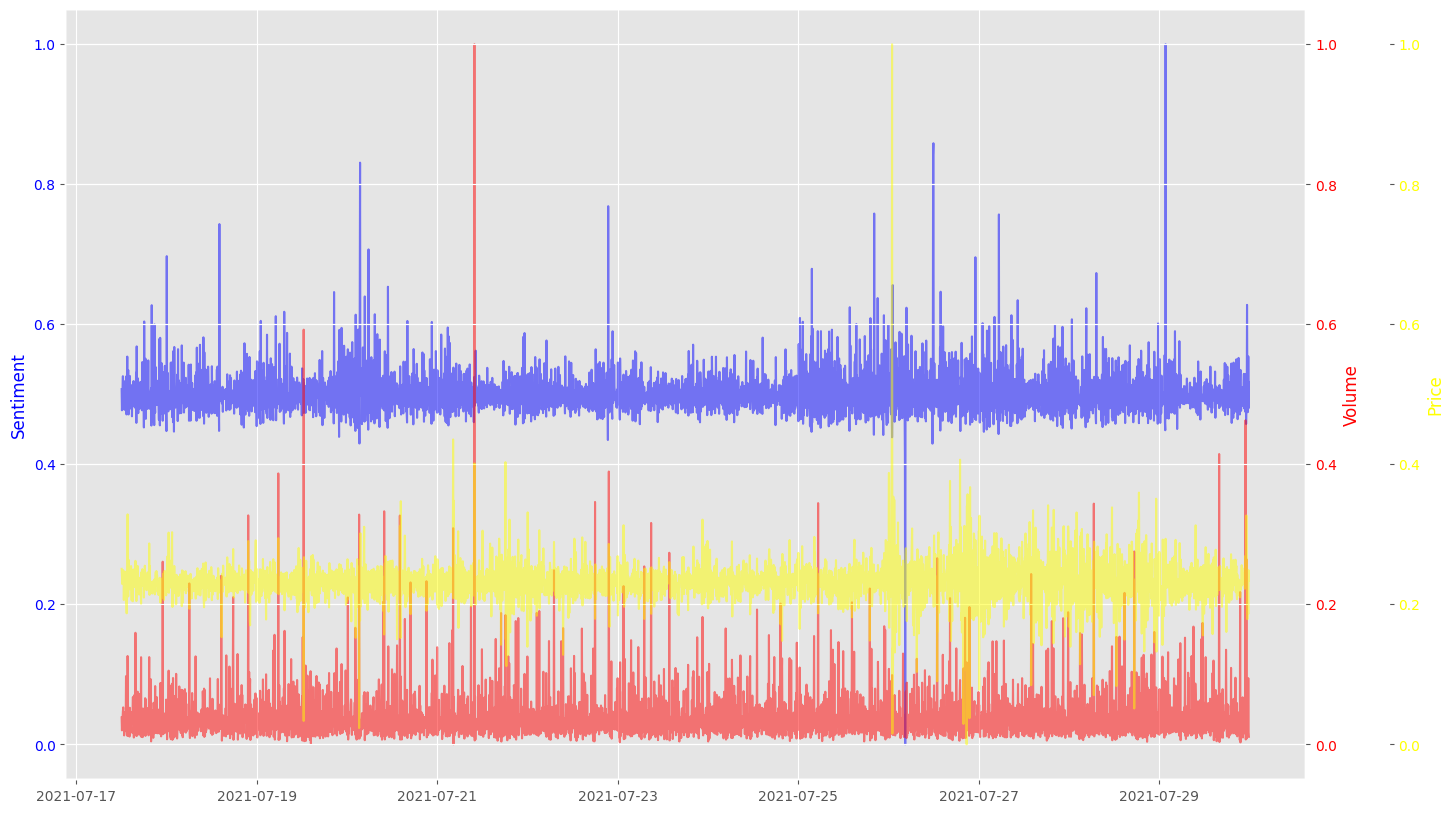

In [148]:
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot the first time series on the first y-axis and set its color
ax1.plot(m5_df.index, m5_df["compound_diffs"], color='blue', alpha=0.5)
ax1.set_ylabel('Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the same x-axis
ax2 = ax1.twinx()
ax2.plot(m5_df.index, m5_df["volume"], color='red', alpha=0.5)
ax2.set_ylabel('Volume', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Create a third y-axis for the same x-axis
ax3 = ax1.twinx()
# Offset the third axis to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(m5_df.index, m5_df["roc"], color='yellow', alpha=0.5)
ax3.set_ylabel('Price', color='yellow')
ax3.tick_params(axis='y', labelcolor='yellow')

plt.show()

In [149]:
m5_df

,close,compound,roc,compound_diffs,volume
2021-07-17 12:00:00,31336.16,0.193783,NaN,NaN,NaN
2021-07-17 12:05:00,31384.01,0.221316,0.250615,0.507390,0.038379
2021-07-17 12:10:00,31410.99,0.158877,0.242005,0.477143,0.019892
2021-07-17 12:15:00,31406.16,0.153381,0.228928,0.494792,0.034784
2021-07-17 12:20:00,31450.43,0.185848,0.249101,0.512352,0.036602
...,...,...,...,...,...
2021-07-29 23:35:00,40134.90,0.224949,0.231963,0.487912,0.016447
2021-07-29 23:40:00,40089.97,0.153538,0.216467,0.474624,0.014715
2021-07-29 23:45:00,39950.81,0.275984,0.186121,0.554122,0.094467
2021-07-29 23:50:00,40005.28,0.209935,0.248505,0.480195,0.017090


In [172]:
order = (8, 1, 10)
# Fit the model
model = ARIMA(m5_df["roc"][1:], order=order)
model_fit = model.fit()

# Print out the summary of the fit
print(model_fit.summary())

/home/hamid/src/envs/global/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/hamid/src/envs/global/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/hamid/src/envs/global/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)
/home/hamid/src/envs/global/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    roc   No. Observations:                 3599
Model:                ARIMA(8, 1, 10)   Log Likelihood                7284.929
Date:                Tue, 05 Mar 2024   AIC                         -14531.858
Time:                        16:45:31   BIC                         -14414.283
Sample:                    07-17-2021   HQIC                        -14489.956
                         - 07-29-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1672      0.194     -6.023      0.000      -1.547      -0.787
ar.L2         -1.8766      0.263     -7.144      0.000      -2.391      -1.362
ar.L3         -1.9424      0.328     -5.915      0.0

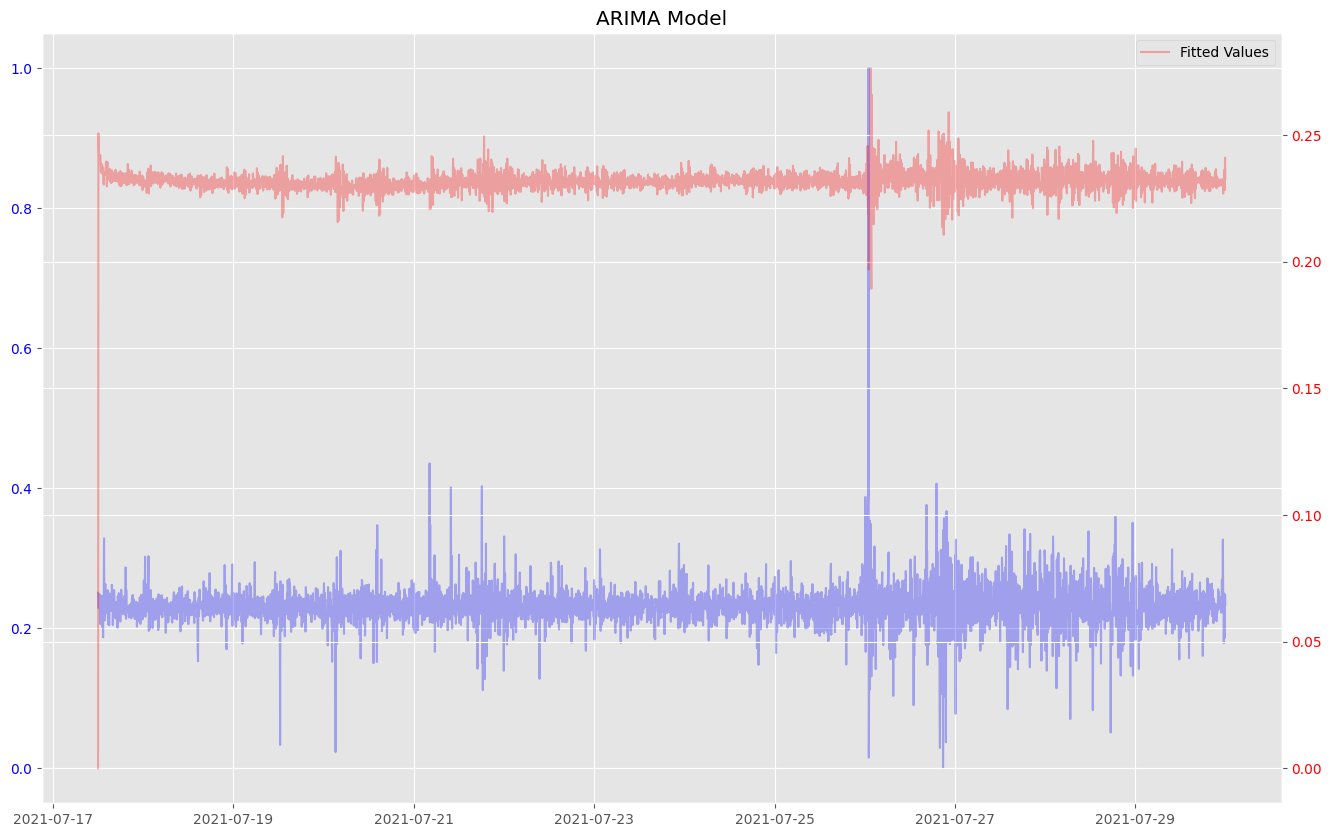

In [178]:
import matplotlib.pyplot as plt

# Get the fitted values
fitted_values = model_fit.fittedvalues

fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot the first time series on the first y-axis and set its color
ax1.plot(m5_df['roc'], color='blue', label='Original Series', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the same x-axis
ax2 = ax1.twinx()
ax2.plot(fitted_values, color='red', label='Fitted Values', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('ARIMA Model')
plt.legend()
plt.show()


In [87]:
cross = np.correlate(m5_df["compound_diffs"][1:], m5_df["volume"][1:], mode="full")

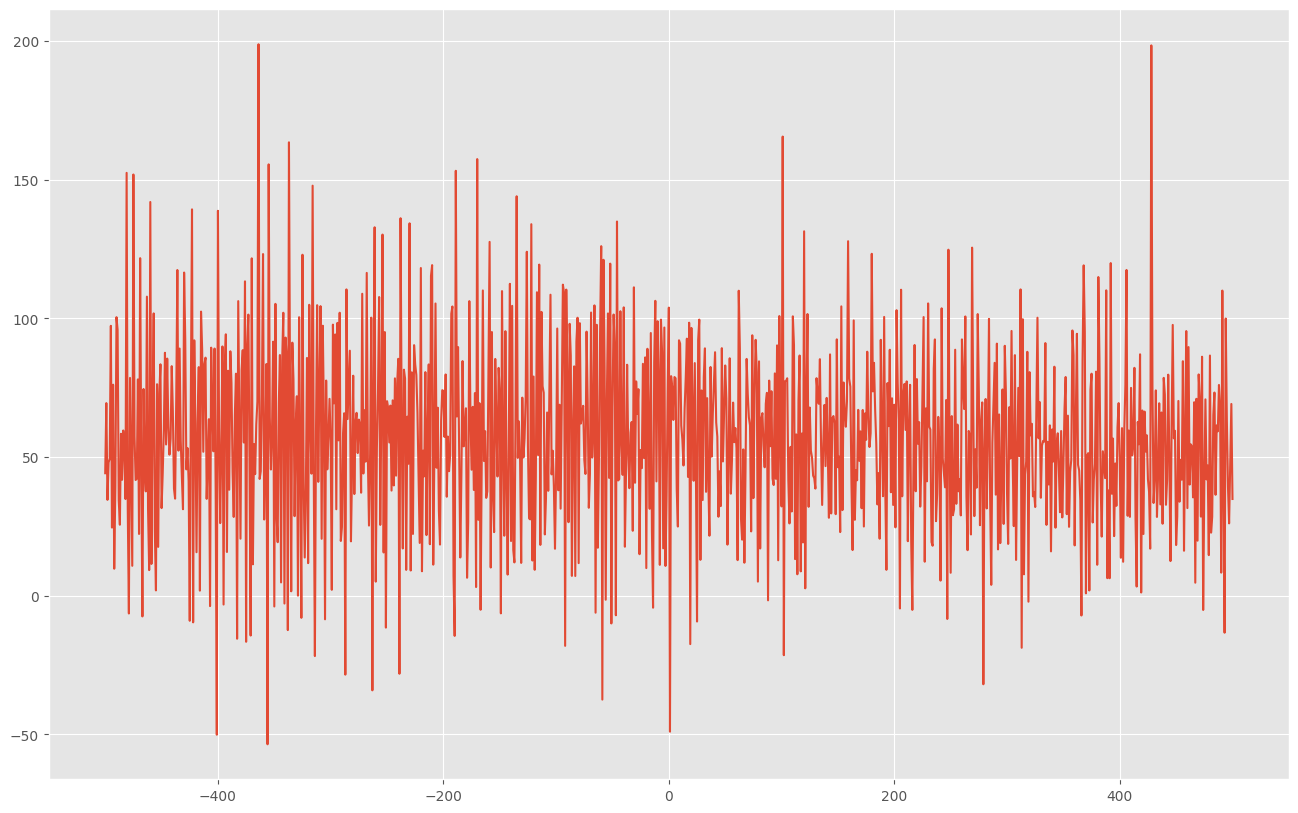

In [88]:
plt.figure(figsize=(16, 10))
lag_size = 500
lags = np.arange(-lag_size, lag_size + 1)
plt.plot(lags, cross[len(cross)//2 - 501 : len(cross)//2 + 500])

In [89]:
np.argmax(cross) - 3600

-367

In [184]:
# Select the time series
data = m5_df[['roc', 'compound']].dropna()
# Create the VAR model
model = VAR(data)

# Fit the model with the optimal lag order
results = model.fit(maxlags=15, ic='aic')

# Print the summary
print(results.summary())

/home/hamid/src/envs/global/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Mar, 2024
Time:                     17:28:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.1860
Nobs:                     3586.00    HQIC:                  -12.2459
Log likelihood:           11893.8    FPE:                4.64795e-06
AIC:                     -12.2791    Det(Omega_mle):     4.57874e-06
--------------------------------------------------------------------
Results for equation roc
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.227132         0.014486           15.680           0.000
L1.roc              -0.040615         0.016745           -2.426           0.015
L1.compound          0.004129         0.008010            0.515   

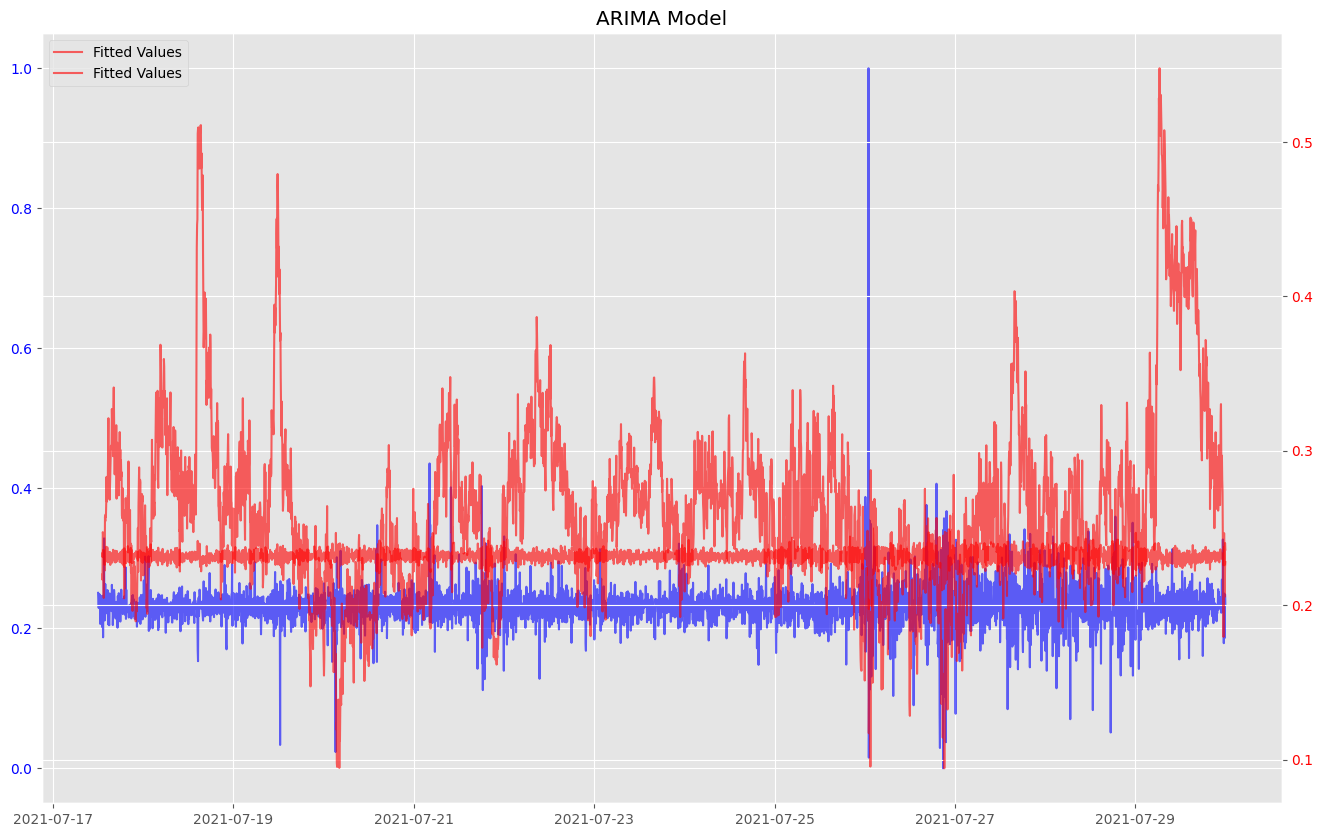

In [186]:
import matplotlib.pyplot as plt

# Get the fitted values
fitted_values = results.fittedvalues

fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot the first time series on the first y-axis and set its color
ax1.plot(m5_df['roc'], color='blue', label='Original Series', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the same x-axis
ax2 = ax1.twinx()
ax2.plot(fitted_values, color='red', label='Fitted Values', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('ARIMA Model')
plt.legend()
plt.show()

### selecting the suitable MA/EMA hyperparameter (assuming the context improves the sentiment index)

### storing the selected index as a dataset to be used later